# Early-State Stress-Thickness Fitting: Ag

This notebook demonstrates the early-state fitting workflow for stress-thickness
curves of Ag thin films in the nucleation/coalescence regime (Mode 4). Unlike
the general model (Mode 1), the early-state model uses ellipsoidal grain-cap
geometry with grain boundary area derivatives (dA/dt).

**Reference:** T. Su, E. Chason, "Analysis of early stage stress during
Volmer-Weber growth of polycrystalline thin films," *Acta Materialia* 301,
121534 (2025).

**Material:** Ag (Silver)
**Datasets:** 7 temperatures (193–373 K) + 2 deposition rate variants at 303 K
**Optimization:** scipy `least_squares` with `soft_l1` loss

To fit Au or Ni instead, change `MATERIAL` in cell 2 and adjust `legend_names`
accordingly. Pre-configured `mainfile.xlsx` files with paper-calibrated initial
parameters are provided for all three materials.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import least_squares
from pathlib import Path

%matplotlib inline

# Add repo root to path
REPO_ROOT = Path('..').resolve().parent
sys.path.insert(0, str(REPO_ROOT))
from kmorfs.stress_equation_early_state import es_stress_equation, compute_initial_pre_term

try:
    matplotlib.rcParams['font.family'] = 'Times New Roman'
except Exception:
    pass

print('Imports successful')

Imports successful


In [2]:
# ===== Configuration =====
MATERIAL = "Ag"

SCRIPT_DIR = Path('..').resolve()
DATA_DIR = SCRIPT_DIR / 'data'
DISCRETIZE_NUM = 1000
CONST_MATERIAL = 12

COLORS = np.array([
    '#5B9BD5', '#A5D6A7', '#F1C40F', '#E74C3C',
    '#9B59B6', '#F39C12', '#1F77B4', '#BDC3C7',
    '#17A589', '#C2185B', '#008B8B'
])

print(f'Material: {MATERIAL}')
print(f'Data directory: {DATA_DIR / MATERIAL}')

Material: Ag
Data directory: D:\KMORFS_local\KMORFS-db\early_state_stress_thickness\data\Ag


In [3]:
# Import helper functions from the fitting script
sys.path.insert(0, str(SCRIPT_DIR))
from fit_early_state_stress import (
    load_data, parse_config, train_model,
    _materials_extend, _param_matrix_extend,
)

# Load data
mainfile, fit_data, scatter_data = load_data(MATERIAL, DATA_DIR)
fit_data = fit_data.reset_index(drop=True)

n_datasets = fit_data['Index'].nunique()
print(f'Found {n_datasets} datasets')
print(f'Total data points: {len(fit_data)}')

Found 9 datasets
Total data points: 293


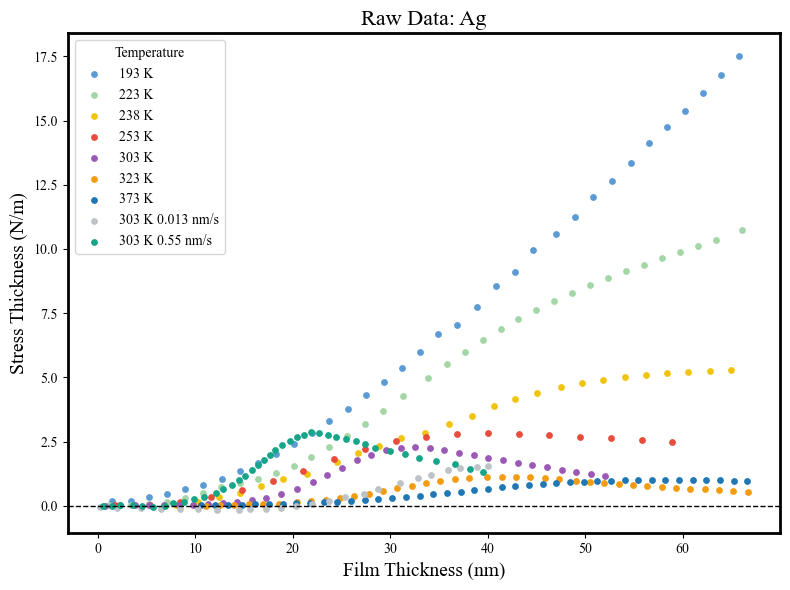

In [4]:
# Plot raw data
fig, ax = plt.subplots(figsize=(8, 6))

legend_names = ['193 K', '223 K', '238 K', '253 K', '303 K',
                '323 K', '373 K', '303 K 0.013 nm/s', '303 K 0.55 nm/s']

for idx in sorted(scatter_data['Index'].unique()):
    subset = scatter_data[scatter_data['Index'] == idx]
    label = legend_names[idx - 1] if idx <= len(legend_names) else f'Dataset {idx}'
    ax.scatter(subset.iloc[:, 0], subset.iloc[:, 1],
               color=COLORS[(idx - 1) % len(COLORS)], s=15, label=label)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Film Thickness (nm)', fontsize=14)
ax.set_ylabel('Stress Thickness (N/m)', fontsize=14)
ax.set_title(f'Raw Data: {MATERIAL}', fontsize=16)
ax.legend(title='Temperature', fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.tight_layout()
plt.show()

In [5]:
# Parse configuration and run optimization
config = parse_config(mainfile)

print(f'Variable parameter names: {config["var_names"]}')
print(f'Free parameters: {len(config["x_vector"])}')
print(f'\nInitial values: {config["x_vector"]}')
print(f'Lower bounds:   {config["lb"]}')
print(f'Upper bounds:   {config["ub"]}')

Variable parameter names: ['SigmaC', 'L_nul', 'alpha1']
Free parameters: 27

Initial values: [-6.12945200e+00 -5.29976100e+00 -5.31652800e+00 -5.19654800e+00
 -5.34136600e+00 -5.40186200e+00 -5.24963700e+00 -4.97067600e+00
 -5.91433800e+00  3.49215550e+01  5.45741740e+01  9.58879760e+01
  1.26766619e+02  1.40084324e+02  1.85532075e+02  1.70518564e+02
  1.51401177e+02  9.15427150e+01  1.51151000e-01  2.75022000e-01
  2.88304000e-01  4.00792000e-01  4.00497000e-01  1.34947400e+00
  1.76718500e+00  3.99996000e-01  4.00569000e-01]
Lower bounds:   [-1.22589040e+01 -1.05995220e+01 -1.06330560e+01 -1.03930960e+01
 -1.06827320e+01 -1.08037240e+01 -1.04992740e+01 -9.94135200e+00
 -1.18286760e+01  3.49215550e+00  5.45741740e+00  9.58879760e+00
  1.26766619e+01  1.40084324e+01  1.85532075e+01  1.70518564e+01
  1.51401177e+01  9.15427150e+00  1.51151000e-02  2.75022000e-02
  2.88304000e-02  4.00792000e-02  4.00497000e-02  1.34947400e-01
  1.76718500e-01  3.99996000e-02  4.00569000e-02]
Upper bound

In [6]:
# Run optimization
result, scaler_X, scaler_rawY, scaler_fitY, hyper_info, full_region_thickness = \
    train_model(config, fit_data)

print(f'\nOptimization cost: {result.cost:.6f}')
print(f'Number of function evaluations: {result.nfev}')


=== Optimization round 1/5 ===
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.9066e+01                                    4.44e+01    
       1              2         9.5512e+01      3.55e+00       6.36e-01       3.89e+01    
       2              3         9.3121e+01      2.39e+00       6.07e-01       2.91e+01    
       3              4         9.1668e+01      1.45e+00       2.89e-02       3.33e+01    
       4              5         8.8673e+01      2.99e+00       9.49e-01       3.58e+01    
       5              6         8.7860e+01      8.14e-01       2.96e-01       2.15e+01    
       6              7         8.7304e+01      5.55e-01       2.01e-02       2.92e+01    
       7              8         8.6799e+01      5.05e-01       3.78e-02       3.27e+01    
       8              9         8.6235e+01      5.64e-01       2.74e-02       2.91e+01    
       9             10         8.5877e+01      3.58e-01  

In [7]:
# Extract optimized parameters
optimized_scaled = result.x
ub, lb = config['ub'], config['lb']
vector_param = optimized_scaled * (ub - lb) + lb
full_vector = _materials_extend(vector_param, config['float_material_ids'],
                                config['full_vector'])
param_M = _param_matrix_extend(full_vector, config['variable_group'],
                               config['variable_info'], config['var_names'],
                               config['constant_vars'])

print('Optimized Parameters:')
display(param_M)

Optimized Parameters:


,SigmaC,L_nul,alpha1,Sigma0,BetaD,Ea,Mfda,K0,alpha2,Di,P0,A prime,B prime,L prime,Grain size,K1,Compsition
0,-1.456696e-07,36.392808,0.287187,1.344027,1.491128,0.231155,9.798693,0,0,0,0,0,0,0,0,0,0
1,-1.059921e+01,52.690649,0.027553,1.344027,1.491128,0.231155,9.798693,0,0,0,0,0,0,0,0,0,0
2,-1.063292e+01,84.421348,0.547778,1.344027,1.491128,0.231155,9.798693,0,0,0,0,0,0,0,0,0,0
3,-1.039172e+01,99.786374,0.761430,1.344027,1.491128,0.231155,9.798693,0,0,0,0,0,0,0,0,0,0
4,-1.068228e+01,105.045299,0.760926,1.344027,1.491128,0.231155,9.798693,0,0,0,0,0,0,0,0,0,0
5,-1.080372e+01,131.618668,2.564001,1.344027,1.491128,0.231155,9.798693,0,0,0,0,0,0,0,0,0,0
6,-9.747839e+00,64.159498,3.333790,1.344027,1.491128,0.231155,9.798693,0,0,0,0,0,0,0,0,0,0
7,-9.941313e+00,85.803302,0.586997,1.344027,1.491128,0.231155,9.798693,0,0,0,0,0,0,0,0,0,0
8,-1.182867e+01,55.987961,0.761078,1.344027,1.491128,0.231155,9.798693,0,0,0,0,0,0,0,0,0,0


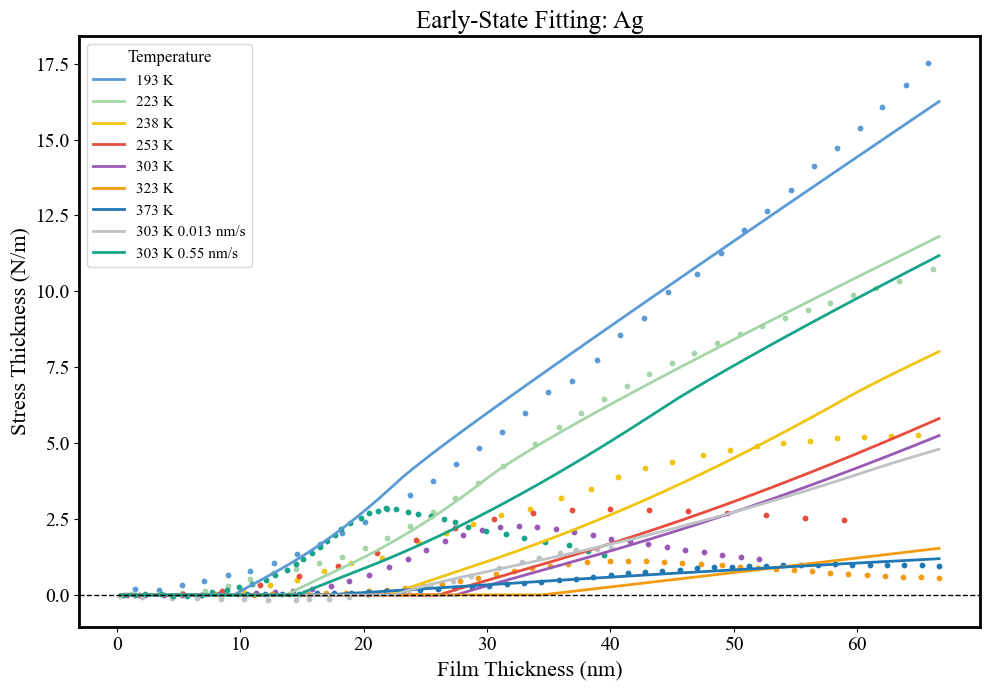

In [8]:
# Plot fitted vs experimental results
fig, ax = plt.subplots(figsize=(10, 7))

for plot_id in sorted(fit_data['Index'].unique()):
    target_info = fit_data[fit_data['Index'] == plot_id].reset_index(drop=True)
    R_data = target_info.iloc[0, 2]
    T_data = target_info.iloc[0, 3]
    P_data = target_info.iloc[0, 4]

    variable_vector = param_M.iloc[plot_id - 1]
    Grain_nul = variable_vector['L_nul']
    pre_term = compute_initial_pre_term(Grain_nul, full_region_thickness[0])

    kinetic_accum = 0
    fit_stress = np.full(len(full_region_thickness), np.nan)
    fit_stress[0] = variable_vector['K0']

    for i in range(len(full_region_thickness) - 1):
        out = es_stress_equation(
            variable_vector, R_data, P_data, T_data,
            full_region_thickness[i + 1], pre_term
        )
        pre_term = out[4]
        kinetic_accum += out[1]
        fit_stress[i + 1] = kinetic_accum + out[2]

    color = COLORS[(plot_id - 1) % len(COLORS)]
    label = legend_names[plot_id - 1] if plot_id <= len(legend_names) else f'Dataset {plot_id}'
    ax.plot(full_region_thickness, fit_stress, color=color, linewidth=2, label=label)

    raw = scatter_data[scatter_data['Index'] == plot_id]
    ax.scatter(raw.iloc[:, 0], raw.iloc[:, 1], color=color, s=10)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Film Thickness (nm)', fontsize=16)
ax.set_ylabel('Stress Thickness (N/m)', fontsize=16)
ax.set_title(f'Early-State Fitting: {MATERIAL}', fontsize=18)
ax.legend(title='Temperature', fontsize=11, title_fontsize=12)
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

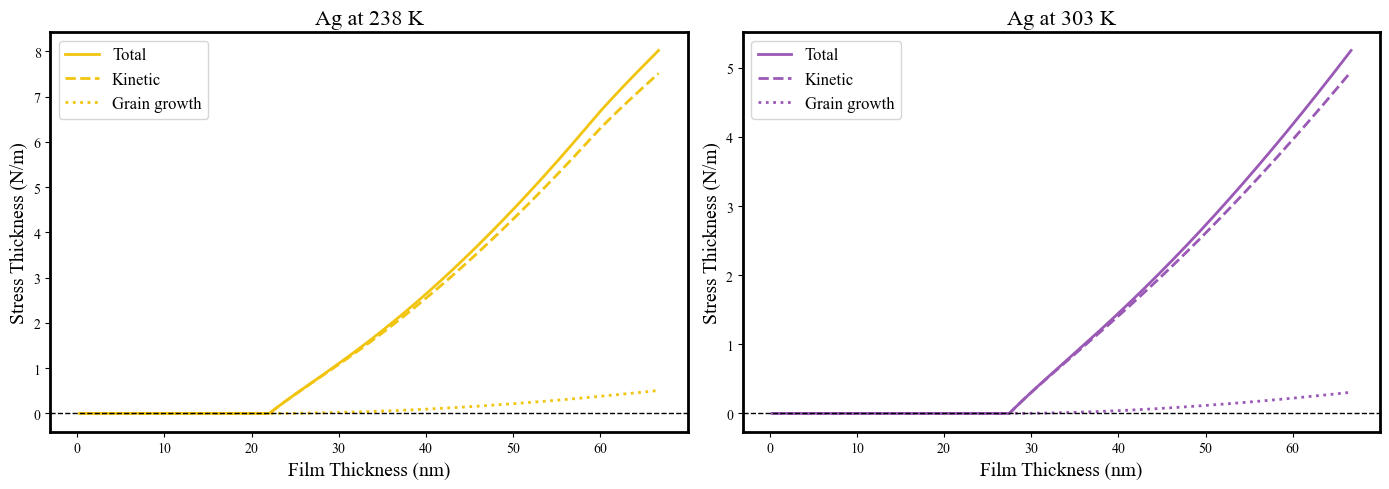

In [9]:
# Separate kinetic vs grain growth contributions for two temperatures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sep_ids = [3, 5]  # 238 K and 303 K
sep_labels = ['238 K', '303 K']

for ax_idx, (plot_id, temp_label) in enumerate(zip(sep_ids, sep_labels)):
    ax = axes[ax_idx]
    target_info = fit_data[fit_data['Index'] == plot_id].reset_index(drop=True)
    R_data = target_info.iloc[0, 2]
    T_data = target_info.iloc[0, 3]
    P_data = target_info.iloc[0, 4]

    variable_vector = param_M.iloc[plot_id - 1]
    Grain_nul = variable_vector['L_nul']
    pre_term = compute_initial_pre_term(Grain_nul, full_region_thickness[0])

    kinetic_accum = 0
    total = np.full(len(full_region_thickness), np.nan)
    kinetic_arr = np.full(len(full_region_thickness), np.nan)
    grain_growth_arr = np.full(len(full_region_thickness), np.nan)
    total[0] = variable_vector['K0']
    kinetic_arr[0] = 0
    grain_growth_arr[0] = 0

    for i in range(len(full_region_thickness) - 1):
        out = es_stress_equation(
            variable_vector, R_data, P_data, T_data,
            full_region_thickness[i + 1], pre_term
        )
        pre_term = out[4]
        kinetic_accum += out[1]
        total[i + 1] = kinetic_accum + out[2]
        kinetic_arr[i + 1] = kinetic_arr[i] + out[1]
        grain_growth_arr[i + 1] = out[2]

    color = COLORS[(plot_id - 1) % len(COLORS)]
    ax.plot(full_region_thickness, total, '-', color=color, linewidth=2, label='Total')
    ax.plot(full_region_thickness, kinetic_arr, '--', color=color, linewidth=2, label='Kinetic')
    ax.plot(full_region_thickness, grain_growth_arr, ':', color=color, linewidth=2, label='Grain growth')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Film Thickness (nm)', fontsize=14)
    ax.set_ylabel('Stress Thickness (N/m)', fontsize=14)
    ax.set_title(f'{MATERIAL} at {temp_label}', fontsize=16)
    ax.legend(fontsize=12)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

plt.tight_layout()
plt.show()